<div class="alert alert-block alert-info"><h1>各省新冠病毒确诊人数的数据可视化</h1></div>

<div class="alert alert-block alert-success"> <h3>作者：1907020121 程元烁</h3></div> 

## 1 代码目的

利用获取的各省新冠病毒确诊人数数据绘制疫情地图


## 2 数据及其他所需材料准备

### 2.1 数据来源

"新型肺炎实时疫情追踪"，链接:"http://m.look.360.cn/subject/400?sign=360_6aa05217"
>提示:这里仅使用各省人数数据，获取数据后保存为csv文件，格式为左边一列省名，右边一列人数。

### 2.2 相关材料下载

pyproj与basemap:"https://www.lfd.uci.edu/~gohlke/pythonlibs/" 
地图轮廓:"http://www.gadm.org/country"
>提示:由于某些文件下载速度缓慢等原因，本模板及用到的所有数据及素材均已上传到github:""

## 3 详细代码

### 3.1 加载库

In [1]:
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon,Patch
import json
import numpy as np
from matplotlib.colors import rgb2hex

### 3.2 数据处理及文件转换

In [2]:
# 指定encodeing='utf-8'中文防止乱码，防止后序处理带有BOM的文件时出错，读取csv文件时采用'utf-8-sig'
with open('E:/Python/projects/virue_1902/province_data.csv','r', encoding='utf-8-sig') as csvfile:
    with open('E:/Python/projects/virue_1902/province_data.json', 'w',encoding='utf-8') as jsonfile:
        
        #指定列名
        fieldnames = ("province", "number")
        
        #将csv文件的数据取出，并生成以键值对形式储存json文件
        reader = csv.DictReader( csvfile, fieldnames)
        
        #分别取出province和number的值，将两个列表拼接为一个字典
        dicts = [ dict(row) for row in reader ]
        dic = dict(zip([key['province'] for key in dicts],[int(val['number']) for val in dicts]))
        jsonfile.write(str(dic).replace("\'","\""))
        

### 3.3  绘图相关函数

#### 3.3.1 根据数据返回颜色

In [3]:
#cmap为调色板，vmin，vmax，val分别为人数最值和该省人数
def colors(cmap,vmin,vmax,val):
    return (cmap(3*np.sqrt((val - vmin) / (vmax - vmin)))[:3])

#### 3.3.2 绘制地图（除南海诸岛）

In [4]:
def virus_map(pop_dic,cmap,vmin,vmax,llcrnrlon_,llcrnrlat_,urcrnrlon_,urcrnrlat_,projection_,lat_0_,lon_0_):
    
    #初始化时选择使用兰勃特投影，参数为经纬度和投影方式
    m = Basemap(llcrnrlon=llcrnrlon_, llcrnrlat=llcrnrlat_, urcrnrlon=urcrnrlon_, urcrnrlat=urcrnrlat_, projection=projection_, lat_0=lat_0_,lon_0=lon_0_)
    
    #读取除台湾省外的中国轮廓，除台湾省外各省级行政区轮廓，台湾省轮廓，南海九段线，南海诸岛的shp文件。
    m.readshapefile('/Python/projects/virue_1902/map/china_exTW/gadm36_CHN_0', 'china', drawbounds=True)
    m.readshapefile('/Python/projects/virue_1902/map/china_exTW/gadm36_CHN_1', 'states', drawbounds=True)
    m.readshapefile('/Python/projects/virue_1902/map/taiwan/gadm36_TWN_0', 'taiwan', drawbounds=True)
    m.readshapefile('/Python/projects/virue_1902/map/south_china_sea/nine_dashed_line', 'nine_dashed_line', drawbounds=True)
    m.readshapefile('/Python/projects/virue_1902/map/south_china_sea/south_china_sea', 'south_china_sea', drawbounds=True)
    
    #获取当前axes
    ax = plt.gca()
    
    #省名称与数据匹配，shp文件中省名称为全称，我们获取的数据中为简称，因此需做相关调整
    for i in range(len(m.states_info)):
        statename = m.states_info[i]['NL_NAME_1']
        s = statename.split('|')[-1]
        if s=="黑龍江省":
            pop=pop_dic['黑龙江']
        elif s=='内蒙古自治区':
            pop=pop_dic['内蒙古']
        else:
            pop = pop_dic[s[:2]]
            
        #原pop储存该省数据，以下将数据分段，并保证颜色对比度。
        if pop<10:
            pop=9
        elif pop<100:
            pop=99
        elif pop<500:
            pop=300
        elif pop<1000:
            pop=500
        else:
            pop=8000
        color = colors(cmap,vmin,vmax,pop)
        poly = Polygon(m.states[i], facecolor=rgb2hex(color))
        #添加patch，绘图完成
        ax.add_patch(poly)
        
        #同理绘制台湾省
    color_tai = (cmap(3*np.sqrt((pop_dic['台湾'] - vmin) / (vmax - vmin)))[:3])
    for seg in m.taiwan:
        poly = Polygon(seg, facecolor= rgb2hex(color_tai))
        ax.add_patch(poly)

#### 3.3.3 绘制图例

In [5]:
def legend(cmap,vmin,vmax,left,bottom,size,length):        
    color = [colors(cmap,vmin,vmax,8000),colors(cmap,vmin,vmax,500),colors(cmap,vmin,vmax,300),colors(cmap,vmin,vmax,99),colors(cmap,vmin,vmax,9)]
    labels = ['>=1000', '500-999', '100-499', '10-99','<10']
    patches = [ Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 
    ax1=plt.gca()
    ax1.legend(handles=patches, bbox_to_anchor=(left,bottom),fontsize=size,frameon=False,handlelength=length,labelspacing=0.5,fancybox=True,ncol=1) 
#frameon为是否显示外面的方框，ncol为列数

### 3.4 执行代码

e:\python\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
e:\python\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
e:\python\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
e:\python\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
e:\python\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3

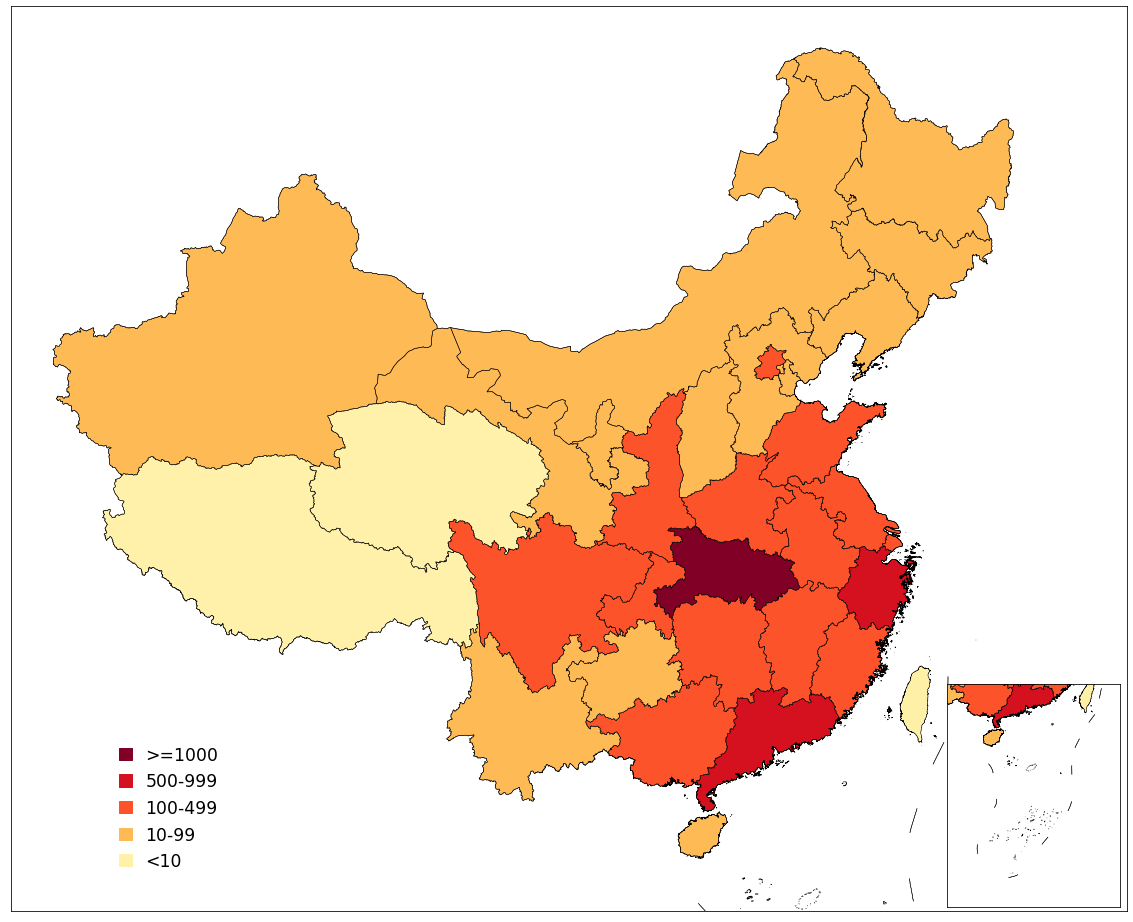

In [6]:
#创建figure
fig=plt.figure(figsize=(20,21))

#读取json文件,取出最值
with open('E:/Python/projects/virue_1902/province_data.json',encoding='utf-8-sig') as json_file:
        pop_dic = json.load(json_file)
vmax = max(pop_dic.values())
vmin = min(pop_dic.values())

#调色板，含红黄两色
cmap = plt.cm.YlOrRd

#绘图
virus_map(pop_dic,cmap,vmin,vmax,78,14,145,51,'lcc',33,100) #“lcc”为兰勃特投影
legend(cmap,vmin,vmax,0.2,0.2,'xx-large',0.7)

#要绘制南海诸岛的画中画效果，可另建立一个axes放于右下角，在其中再次绘图，经纬度位置调整为南海位置即可
left,bottom,width,height = 0.775,0.2,0.12,0.16
ax2 = fig.add_axes([left,bottom,width,height])  
virus_map(pop_dic,cmap,vmin,vmax,105,0,125,25,'lcc',12,115)

#储存图片:fig.savefig("E:/Python/projects/virue_1902/map.png")
plt.show()